# Course 5 Project: Building a Reinforcement Learning Trading Model

## 0. Introduction

In this project, you'll embark on an exciting journey to design, encode, and train a trading agent from scratch using reinforcement learning (RL). By the end of this project, you'll have a hands-on understanding of how RL can be applied to the financial markets, empowering you to create intelligent agents capable of making trading decisions.

### Relevant Concepts in this Project:
- Intermediate Python & Tensorflow: This project requires an intermediate understanding of Python, including Tensorflow.
- Reinforcement Learning Basics: Understanding the fundamentals of RL, including key concepts such as agents, environments, actions, states, and rewards.
- Deep Q-Networks (DQN): Understanding the architecture and mechanics of DQN, a popular RL algorithm used for training trading agents.
- Reward Functions: Understanding how to design effective reward functions that guide your agent towards profitable trading strategies.
- Agent Training: Gaining practical experience in encoding and training your trading agent, including handling data, optimizing the DQN model via experience replay, and interpreting the training process output.

**NOTE:** **The references of this project included the course materials, the documents of Numpy, Pandas, matplotlib, Skit-Learn, TensorFlow, Google search, and ChatGPT.**

# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Google stock price (1d bars) for the year 2010

In [1]:
# Load Python Libraries
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import register_keras_serializable

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
keras.utils.set_random_seed(42)

# number of features in your input state
state_size = 3
# number of actions (e.g., 3 for buy, sell, hold)
action_size = 3


2025-01-15 21:34:53.505177: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Download Sample Data
data_df = pd.read_csv('GOOG_2009-2010_6m_RAW_1d.csv')

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [3]:
# Display as Dataframe
display_df(data_df)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0


In [4]:
# Index data by Date
data_df['Date'] = pd.to_datetime(data_df['Date'])

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       191 non-null    datetime64[ns]
 1   Open       186 non-null    float64       
 2   High       186 non-null    float64       
 3   Low        186 non-null    float64       
 4   Close      186 non-null    float64       
 5   Adj Close  186 non-null    float64       
 6   Volume     186 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 10.6 KB


In [6]:
close_data_df = data_df[['Date', 'Close']]
close_data_df.info()
close_data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    191 non-null    datetime64[ns]
 1   Close   186 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.1 KB


,Date,Close
0,2009-04-01,8.819193
1,2009-04-02,9.028658
2,2009-04-03,9.209979
3,2009-04-06,9.171623
4,2009-04-07,NaN


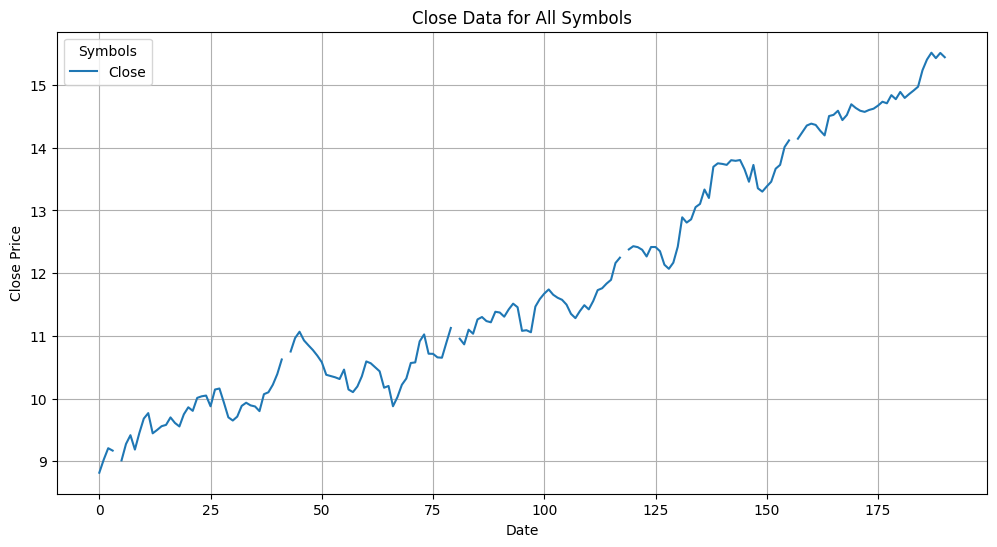

In [7]:
# Plot the Close Data
close_data_df['Close'].plot(figsize=(12, 6), title='Close Data for All Symbols')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title='Symbols', loc='upper left')
plt.grid(True)
plt.show()

# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [8]:
# Check for null values
print("Null values before cleaning:")
print(close_data_df['Close'].isnull().sum())

Null values before cleaning:
5


In [9]:
# Check for NaN values in original 'Close' data
print("Null NaN values before cleaning:")
print(close_data_df['Close'].isna().sum())

Null NaN values before cleaning:
5


In [10]:
# forward fill missing values
close_data_df = close_data_df.ffill()

In [11]:
print(close_data_df.dtypes)

Date     datetime64[ns]
Close           float64
dtype: object


In [12]:
# Check for null values
print("Null values after cleaning:")
print(close_data_df.isnull().sum())

Null values after cleaning:
Date     0
Close    0
dtype: int64


In [13]:
# Check for NaN values
print("Null NaN values after cleaning:")
print(close_data_df.isna().sum())

Null NaN values after cleaning:
Date     0
Close    0
dtype: int64


In [14]:
print(close_data_df.dtypes)

Date     datetime64[ns]
Close           float64
dtype: object


In [15]:
# Convert to numeric to ensure all values are numeric
close_data_df['Close'] = pd.to_numeric(close_data_df['Close'], errors='coerce')
print(close_data_df.info())

# Check for NaN values after conversion (indicating invalid numeric data)
print(close_data_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    191 non-null    datetime64[ns]
 1   Close   191 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.1 KB
None
Date     0
Close    0
dtype: int64


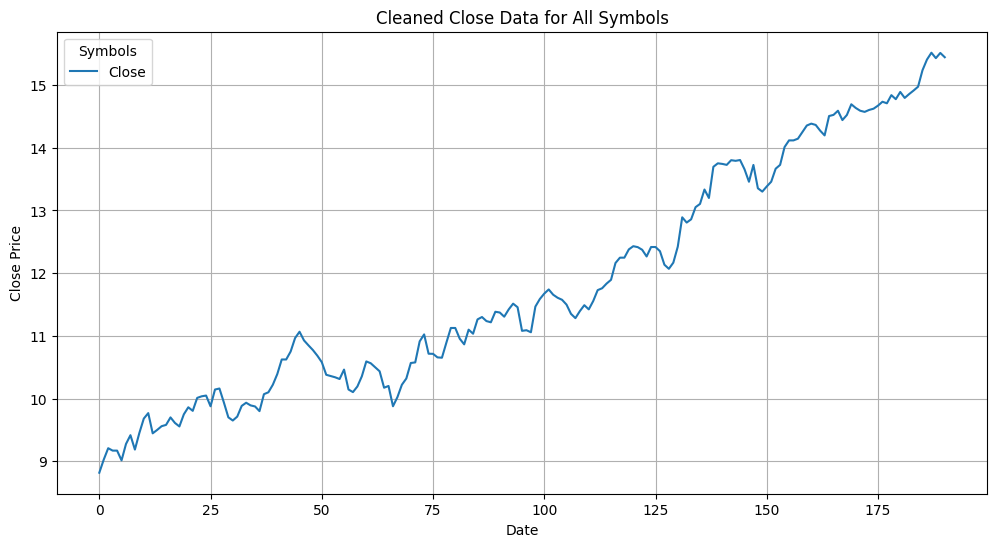

In [16]:
# Plot the cleaned Close Data
close_data_df['Close'].plot(figsize=(12, 6), title='Cleaned Close Data for All Symbols')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title='Symbols', loc='upper left')
plt.grid(True)
plt.show()

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [17]:
close_data_df.head()
close_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    191 non-null    datetime64[ns]
 1   Close   191 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.1 KB


In [18]:
# Calculate 20-day bollinger bands
close_data_df['20-Day MA'] = close_data_df['Close'].rolling(window=20).mean()

In [19]:
close_data_df.info()
close_data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       191 non-null    datetime64[ns]
 1   Close      191 non-null    float64       
 2   20-Day MA  172 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.6 KB


,Date,Close,20-Day MA
0,2009-04-01,8.819193,NaN
1,2009-04-02,9.028658,NaN
2,2009-04-03,9.209979,NaN
3,2009-04-06,9.171623,NaN
4,2009-04-07,9.171623,NaN


In [20]:
print(close_data_df.isna().sum())

Date          0
Close         0
20-Day MA    19
dtype: int64


In [21]:
print(close_data_df.isnull().sum())

Date          0
Close         0
20-Day MA    19
dtype: int64


In [22]:
close_data_df['20-Day STD'] = close_data_df['Close'].rolling(window=20).std()

In [23]:
close_data_df.info()
close_data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        191 non-null    datetime64[ns]
 1   Close       191 non-null    float64       
 2   20-Day MA   172 non-null    float64       
 3   20-Day STD  172 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 6.1 KB


,Date,Close,20-Day MA,20-Day STD
0,2009-04-01,8.819193,NaN,NaN
1,2009-04-02,9.028658,NaN,NaN
2,2009-04-03,9.209979,NaN,NaN
3,2009-04-06,9.171623,NaN,NaN
4,2009-04-07,9.171623,NaN,NaN


In [24]:
# Calculate Upper and Lower Bollinger Bands
close_data_df['BB_upper'] = close_data_df['20-Day MA'] + (2 * close_data_df['20-Day STD'])
close_data_df['BB_lower'] = close_data_df['20-Day MA'] - (2 * close_data_df['20-Day STD'])

In [25]:
close_data_df.info()
close_data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        191 non-null    datetime64[ns]
 1   Close       191 non-null    float64       
 2   20-Day MA   172 non-null    float64       
 3   20-Day STD  172 non-null    float64       
 4   BB_upper    172 non-null    float64       
 5   BB_lower    172 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 9.1 KB


,Date,Close,20-Day MA,20-Day STD,BB_upper,BB_lower
0,2009-04-01,8.819193,NaN,NaN,NaN,NaN
1,2009-04-02,9.028658,NaN,NaN,NaN,NaN
2,2009-04-03,9.209979,NaN,NaN,NaN,NaN
3,2009-04-06,9.171623,NaN,NaN,NaN,NaN
4,2009-04-07,9.171623,NaN,NaN,NaN,NaN


In [26]:
# Remove rows with NaN bollinger bands
bb_cleaned_data = close_data_df[['Close', 'BB_upper', 'BB_lower']].dropna()

In [27]:
bb_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, 19 to 190
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     172 non-null    float64
 1   BB_upper  172 non-null    float64
 2   BB_lower  172 non-null    float64
dtypes: float64(3)
memory usage: 5.4 KB


In [28]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = bb_cleaned_data.copy()

In [29]:
# Verify the dataset
print("Dataset after feature selection:")
print(dataset.head())

Dataset after feature selection:
        Close   BB_upper  BB_lower
19   9.750204   9.937823  8.853717
20   9.862284   9.956057  8.939792
21   9.805497   9.978454  8.995079
22  10.011973  10.053107  9.000625
23  10.037128  10.115385  9.024898


# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

In [30]:
# Display & Plot Un-normalized Dataset
display_df(dataset)

,Close,BB_upper,BB_lower
19,9.750204,9.937823,8.853717
20,9.862284,9.956057,8.939792
21,9.805497,9.978454,8.995079
22,10.011973,10.053107,9.000625
23,10.037128,10.115385,9.024898
24,10.049084,10.165415,9.062614
25,9.878224,10.142584,9.171646
26,10.145223,10.198098,9.202882
27,10.161413,10.256965,9.218412
28,9.938000,10.231943,9.318403


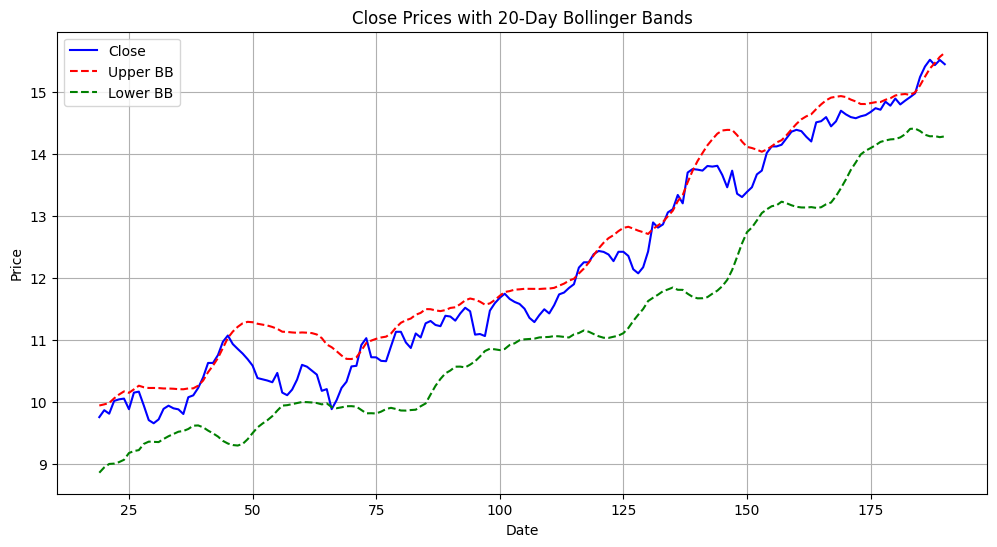

In [31]:
# Plot the Close and Bollinger Bands for visualization
plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset['Close'], label='Close', color='blue')
plt.plot(dataset.index, dataset['BB_upper'], label='Upper BB', color='red', linestyle='--')
plt.plot(dataset.index, dataset['BB_lower'], label='Lower BB', color='green', linestyle='--')
plt.title('Close Prices with 20-Day Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Normalize Dataset with StandardScaler
normlist = []
normed_dataset = pd.DataFrame(index=dataset.index)

for col in dataset.columns:
    normalizer = StandardScaler()
    # fit normalizer to column data
    # transform column data with the fitted normalizer, and place the transformed data column in out normed_dataset df
    # append the fitted normalizer to normlist for use later
    column_data = dataset[[col]]  # Select the column as a DataFrame
    normed_data = normalizer.fit_transform(column_data)  # Fit and transform the column data
    normed_dataset[col] = normed_data.flatten()  # Add the transformed column data to the new DataFrame
    normlist.append(normalizer)  # Save the fitted normalizer for potential inverse transformations


In [33]:
# Display & Plot Normalized Dataset
display_df(normed_dataset)

,Close,BB_upper,BB_lower
19,-1.341805,-1.450150,-1.430416
20,-1.277192,-1.439244,-1.377255
21,-1.309929,-1.425848,-1.343109
22,-1.190897,-1.381197,-1.339683
23,-1.176395,-1.343949,-1.324692
24,-1.169503,-1.314025,-1.301398
25,-1.268002,-1.327681,-1.234058
26,-1.114080,-1.294477,-1.214766
27,-1.104746,-1.259269,-1.205175
28,-1.233542,-1.274234,-1.143419


In [34]:
type(normlist)
print(normlist)

[StandardScaler(), StandardScaler(), StandardScaler()]


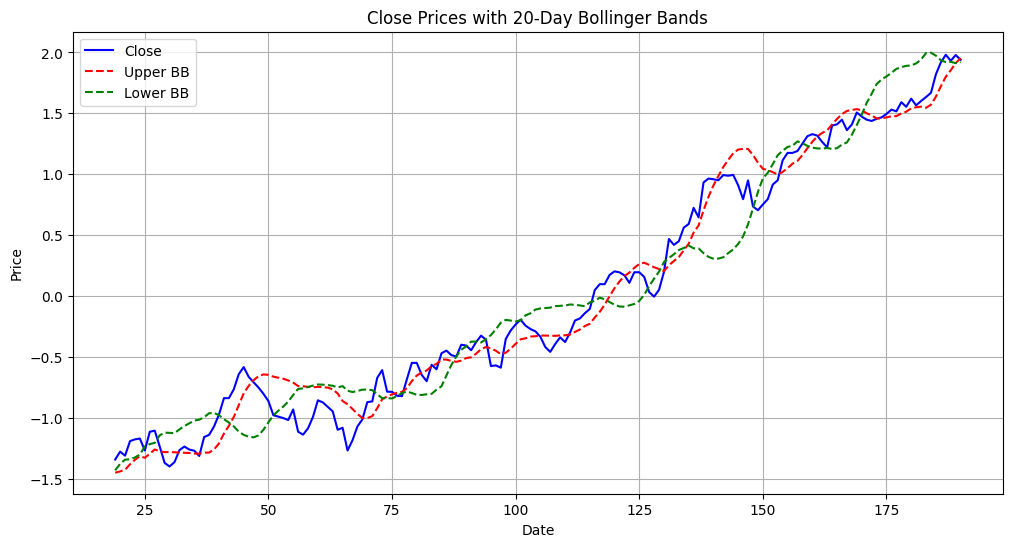

In [35]:
# Plot the Close and Bollinger Bands for visualization
plt.figure(figsize=(12, 6))
plt.plot(normed_dataset.index, normed_dataset['Close'], label='Close', color='blue')
plt.plot(normed_dataset.index, normed_dataset['BB_upper'], label='Upper BB', color='red', linestyle='--')
plt.plot(normed_dataset.index, normed_dataset['BB_lower'], label='Lower BB', color='green', linestyle='--')
plt.title('Close Prices with 20-Day Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data ito train and test data (50/50 split)

In [36]:
# split dataset df into train (50%) and test (50%) datasets
train_df, test_df = train_test_split(normed_dataset, test_size=0.5, random_state=42)

In [37]:
# display train and test dfs (ensure no overlap)
print("Train DataFrame:")
print(train_df)
print("\nTest DataFrame:")
print(test_df)

Train DataFrame:
        Close  BB_upper  BB_lower
98  -0.351930 -0.465153 -0.195620
103 -0.270805 -0.332632 -0.141364
58  -1.085937 -0.745502 -0.746776
116  0.048385 -0.176391 -0.038949
105 -0.333839 -0.324508 -0.101821
180  1.620210  1.540051  1.893118
186  1.917718  1.721223  1.936070
163  1.221044  1.359376  1.215178
66  -1.267715 -0.888046 -0.776838
113 -0.183505 -0.274560 -0.077222
158  1.251053  1.157150  1.253744
80  -0.548498 -0.652277 -0.810661
92  -0.378206 -0.472929 -0.373537
52  -0.989591 -0.670083 -0.941025
139  0.964457  0.814582  0.321585
147  0.949524  1.207462  0.588991
156  1.175096  1.087051  1.233618
81  -0.647141 -0.627862 -0.811706
189  1.978741  1.912249  1.911668
127  0.032734  0.255790  0.081396
130  0.198431  0.204570  0.279499
124  0.195416  0.231908 -0.064906
72  -0.671263 -0.920427 -0.805531
24  -1.169503 -1.314025 -1.301398
145  0.909895  1.202558  0.427460
22  -1.190897 -1.381197 -1.339683
178  1.591062  1.498753  1.878647
68  -1.070142 -0.968324 -0.7790

In [38]:
# print the shape of X_train to remind yourself how many examples and features are in the dataset
# track index to remember which feature is which
# Convert train and test DataFrames to numpy arrays with dtype=float
X_train = train_df.to_numpy(dtype=float)
X_test = test_df.to_numpy(dtype=float)

# Print the shape of X_train to understand the number of examples and features
print("\nShape of X_train:", X_train.shape)

# Track index for feature columns
# Replace 'close', 'bb_upper', and 'bb_lower' with actual column names in your dataset
idx_close = train_df.columns.get_loc('Close')  # Numerical index of 'close' data column
idx_bb_upper = train_df.columns.get_loc('BB_upper')  # Numerical index of 'bb_upper' column
idx_bb_lower = train_df.columns.get_loc('BB_lower')  # Numerical index of 'bb_lower' column

# Print feature indices
print("\nFeature Indices:")
print("Close:", idx_close)
print("Upper BB:", idx_bb_upper)
print("Lower BB:", idx_bb_lower)


Shape of X_train: (86, 3)

Feature Indices:
Close: 0
Upper BB: 1
Lower BB: 2


# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [39]:
print(tf.__version__)

2.17.0


In [40]:
#@tf.keras.saving.register_keras_serializable()
@register_keras_serializable()
# Define DQN ModelArchitecture
class DQN(keras.Model):
    def __init__(self, state_size, action_size, **kwargs):
        super(DQN, self).__init__(**kwargs)
        
        self.state_size = state_size
        self.action_size = action_size
        
        # define model layers in keras
        layers.Input(shape=(state_size,))
        self.fc1 = layers.Dense(64, activation='relu')
        self.fc2 = layers.Dense(32, activation='relu')
        self.fc3 = layers.Dense(8, activation='relu')
        self.output_layer = layers.Dense(action_size, activation='linear')
        
        # compile model in keras
        model = self.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['accuracy']
        )
        
        # save model to DQN instance
        self.model = model
        
    def call(self, inputs):
        # Define the forward pass
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        return self.output_layer(x)

    def get_config(self):
        config = super(DQN, self).get_config()
        config.update({
            "state_size": self.state_size,
            "action_size": self.action_size,
        })
        
        return config

    @classmethod
    def from_config(cls, config):
        # Debug: Print the config dictionary
        print("Deserialization Config:", config)
        # Ensure `state_size` and `action_size` exist
        if "state_size" not in config or "action_size" not in config:
            raise ValueError("Missing `state_size` or `action_size` in config during deserialization.")
        return cls(
            state_size=config['state_size'], 
            action_size=config['action_size'], 
            **{k: v for k, v in config.items() if k not in ["state_size", "action_size"]}
        )

In [41]:
# number of features in your input state
state_size = 3
# number of actions (e.g., 3 for buy, sell, hold)
action_size = 3

dqn = DQN(state_size=state_size, action_size=action_size)
print("Serialization Config:", dqn.get_config())

# Print the model summary
# Create a dummy input
dummy_input = tf.random.uniform((1, state_size))

# Build the model by calling it with input
dqn(dummy_input)

dqn.summary()

Serialization Config: {'name': 'dqn', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'state_size': 3, 'action_size': 3}


Model: "dqn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (1, 64)                │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 32)                │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 8)                 │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 3)                 │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,627 (10.26 KB)

 Trainable params: 2,627 (10.26 KB)

 Non-trainable params: 0 (0.00 B)

### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [42]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size  # Historical data lookback
        self.num_features = num_features  # Features per day
        self.state_size = window_size * num_features  # Total state size
        self.action_size = 3  # Actions: hold, buy, sell
        self.memory = deque(maxlen=1000)  # Replay memory
        self.inventory = []  # Inventory to hold trades
        self.model_name = model_name
        self.test_mode = test_mode  # Testing mode flag

        # Hyperparameters
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01  # Minimum exploration
        self.epsilon_decay = 0.995  # Decay rate for exploration

        # Load pre-trained model in test mode or create a new model
        self.model = keras.models.load_model(model_name, custom_objects={"DQN": DQN}) if test_mode else self._model()
        print("Model Config After Loading:", self.model.get_config())

    # DQL model creation
    def _model(self):
        model = DQN(state_size=self.state_size, action_size=self.action_size)
        return model

    # DQL Predict (with input reshaping)
    #   Input = State
    #   Output = Q-Table of action Q-Values
    def get_q_values_for_state(self, state):
        # Debug statement
        #print(f"[get_q_values_for_state] State shape: {state.shape}, Expected size: {self.state_size}")
        state = state.flatten().reshape(1, self.state_size)
        
        if state.shape[1] != self.state_size:
            raise ValueError(f"[get_q_values_for_state] State size mismatch: {state.shape[1]} vs {self.state_size}")
        return self.model(state).numpy()

    # DQL Fit (with input reshaping)
    #   Input = State, Target Q-Table 
    #   Output = MSE Loss between Target Q-Table and Actual Q-Table for State
    # def fit_model(self, input_state, target_output):
    #    input_state = input_state.flatten().reshape(1, self.state_size)
    #    return self.model.fit(input_state, target_output, epochs=1, verbose=0)
    def fit_model(self, input_state, target_output):
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, epochs=1, verbose=0)    

    # Agent Action Selector
    #   Input = State
    #   Policy = epsilon-greedy (to minimize possibility of overfitting)
    #   Intitially high epsilon = more random, epsilon decay = less random later
    #   Output = Action (0, 1, or 2)
    def act(self, state):
        if not self.test_mode and random.random() <= self.epsilon:
            # Random action
            return random.randrange(self.action_size)
        else:
            # Action with the highest Q-value
            q_values = self.get_q_values_for_state(state)
            return np.argmax(q_values[0])

    # Experience Replay (Learning Function)
    #   Input = Batch of (state, action, next_state) tuples
    #   Optimal Q Selection Policy = Bellman equation
    #   Important Notes = Model fitting step is in this function (fit_model)
    #                     Epsilon decay step is in this function
    #   Output = Model loss from fitting step
    def exp_replay(self, batch_size):
        # Get a random mini-batch from memory
        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))
        losses = []

        for state, action, reward, next_state, done in mini_batch:
            # reminders: 
            #   - state is a vector containing close & MA values for the current time step
            #   - action is an integer representing the action taken by the act function at the current time step- buy, hold, or sell
            #   - reward represents the profit of a given action - it is either 0 (for buy, hold, and sells which loose money) or the profit in dollars (for a profitable sell)
            #   - next_state is a vector containing close & MA values for the next time step
            #   - done is a boolean flag representing whether or not we are in the last iteration of a training episode (i.e. True when next_state does not exist.)
            if done:
                # Terminal state Q-value
                optimal_q_for_action = reward
            else:
                # Bellman equation: Q(s, a) = reward + gamma * max(Q(s', a'))
                next_q_values = self.get_q_values_for_state(next_state)
                optimal_q_for_action = reward + self.gamma * np.max(next_q_values[0])
                
            # Predict current state Q-values
            target_q_values = self.get_q_values_for_state(state)
            #target_q_values[0][action] = optimal_q_for_action  # Update Q-value for the taken action
            
            # Ensure target_q_values is a 2D numpy array
            target_q_values = np.array(target_q_values)  

            # Update Q-value for the specified action
            #print(f"optimal_q_for_action type: {type(optimal_q_for_action)}, shape: {getattr(optimal_q_for_action, 'shape', None)}")
            #print(f"target_q_values type: {type(target_q_values)}, shape: {target_q_values.shape}")

            # Fixing
            if isinstance(optimal_q_for_action, np.ndarray):
                target_q_values[0, action] = optimal_q_for_action.item()  # Explicit scalar conversion
            else:
                target_q_values[0, action] = optimal_q_for_action
            
            # Fit model on updated Q-values
            history = self.fit_model(state, target_q_values)
            losses += history.history['loss']

        # define epsilon decay (for the act function)
        # Decay epsilon to reduce exploration over time
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return losses

# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [43]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    #return 1 / (1 + math.exp(-x))
    return 1 / (1 + np.exp(-np.array(x)))  # Ensure it works with arrays

# Plot behavior of trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/15)), test_df.index.values[0::int(len(test_df.index.values)/15)], rotation=45, fontsize='small')
    plt.show()

# Plot training loss
def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()

# returns an n-day state representation ending at time t
def get_state(data, t, n): 
    # data is the dataset of interest which holds the state values (i.e. Close , BB Upper, BB Lower)
    # t is the current time step 
    # n is the size of the training window 

    # the first step is to get the window of the dataset at the current time step (eg. if window size is 1, we grab the previous and the current time step)
    # remember to define the special case for the first iteration, where there is no previous time step. See lesson X for a reminder of how to do this.
    if t - n + 1 < 0:
        window = data[0:t + 1]
        window = [data[0]] * (n - len(window)) + list(window)
    else:
        window = data[t - n + 1:t + 1]

    # once we have our state data, we need to apply the sigmoid to each feature.
    # return an array holding the n-day sigmoid state representation
    sigmoid_window = [sigmoid(x) for x in window]

    return_state = np.array(sigmoid_window).flatten()[:state_size]
    #print(f"[get_state] state shape: {return_state.shape}")
    return return_state  # Return a 1D array

### Training Loop

In [44]:
# display the shape of your training data in order to remind yourself how many features and examples there are in your training set
print("\nShape of X_train:", X_train.shape)


Shape of X_train: (86, 3)


In [45]:
type(X_train)

numpy.ndarray

In [46]:
keras.utils.disable_interactive_logging()  # disable built-in keras loading bars - they make the output difficult to read and monitor

window_size = 1
num_features = 3

# instatniate the agent using the wndow size and the number of training features
agent = Agent(window_size=window_size, num_features=num_features)

Model Config After Loading: {'name': 'dqn_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'state_size': 3, 'action_size': 3}


In [47]:
normlist

[StandardScaler(), StandardScaler(), StandardScaler()]

In [48]:
keras.config.disable_traceback_filtering() # disable built-in keras loading bars - they make the output difficult to read and monitor

l = len(X_train)  # Number of days in the training dataset

# batch size defines how often to run the exp_replay method
batch_size = 32

#An episode represents a complete pass over the data.
episode_count = 2

normalizer_close = normlist[idx_close]
normalizer_bb_upper = normlist[idx_bb_upper]
normalizer_bb_lower = normlist[idx_bb_lower]

X_train_true_price = normalizer_close.inverse_transform(X_train[:, idx_close].reshape(-1, 1))
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(X_train[:, idx_bb_upper].reshape(-1, 1))
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(X_train[:, idx_bb_lower].reshape(-1, 1))


Running episode 0/2:   0%|          | 0/86 [00:00<?, ?it/s]

Action: Buy, Price: [10.1940403]
Action: Sell, Price: [11.4986496], Profit: [1.3046093]
Action: Buy, Price: [14.19579124]
Action: Sell, Price: [9.87872219], Profit: [-4.31706905]
Action: Buy, Price: [11.12629604]
Action: Buy, Price: [10.36116409]
Action: Buy, Price: [13.75070858]
Action: Buy, Price: [13.72480583]
Action: Sell, Price: [10.95518684], Profit: [-0.1711092]
Action: Buy, Price: [15.51011372]
Action: Buy, Price: [12.13451672]
Action: Sell, Price: [12.42193985], Profit: [2.06077576]
Action: Buy, Price: [12.41670895]
Action: Sell, Price: [10.91334438], Profit: [-2.8373642]
Action: Sell, Price: [10.04908371], Profit: [-3.67572212]
Action: Buy, Price: [13.65606403]
Action: Buy, Price: [14.83763504]
Action: Sell, Price: [10.22143841], Profit: [-5.28867531]
Action: Sell, Price: [11.09043026], Profit: [-1.04408646]
Action: Sell, Price: [10.34024239], Profit: [-2.07646656]
Action: Sell, Price: [10.20201015], Profit: [-3.45405388]
Action: Sell, Price: [10.14522266], Profit: [-4.692412

/tmp/ipykernel_600673/4164842749.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('Total gains: %f'%(profit))


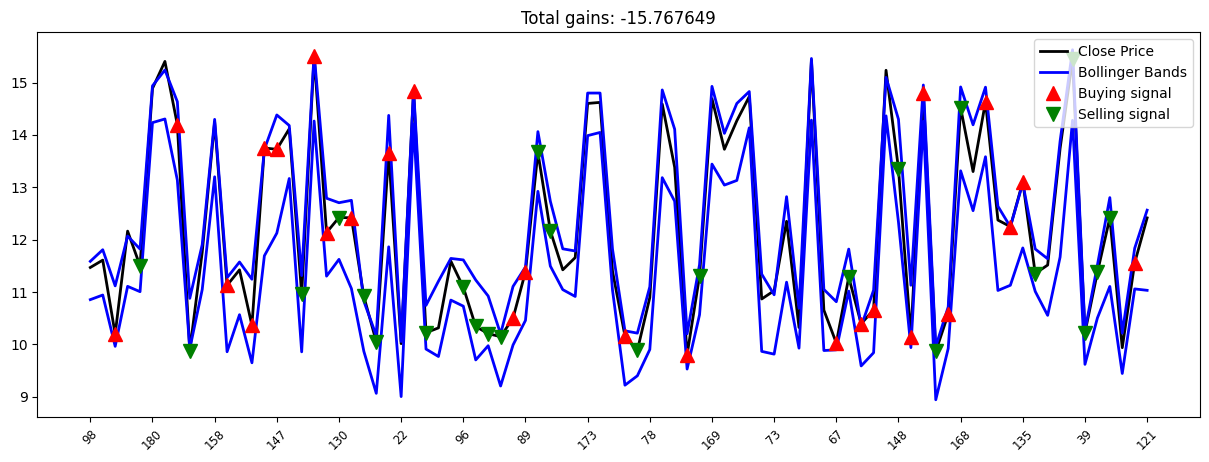

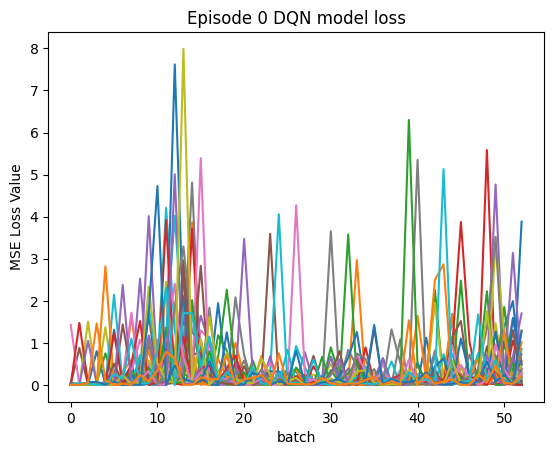

Model Config Before Saving: {'name': 'dqn_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'state_size': 3, 'action_size': 3}


Running episode 1/2:   0%|          | 0/86 [00:00<?, ?it/s]

Action: Buy, Price: [12.16166496]
Action: Buy, Price: [11.4986496]
Action: Sell, Price: [14.88819504], Profit: [2.72653008]
Action: Buy, Price: [15.40426064]
Action: Sell, Price: [14.19579124], Profit: [2.69714165]
Action: Buy, Price: [9.87872219]
Action: Buy, Price: [11.75942326]
Action: Buy, Price: [14.24784565]
Action: Sell, Price: [11.42168903], Profit: [-3.9825716]
Action: Sell, Price: [10.36116409], Profit: [0.4824419]
Action: Buy, Price: [13.75070858]
Action: Sell, Price: [13.72480583], Profit: [1.96538258]
Action: Sell, Price: [14.11608887], Profit: [-0.13175678]
Action: Sell, Price: [10.95518684], Profit: [-2.79552174]
Action: Buy, Price: [15.51011372]
Action: Sell, Price: [12.13451672], Profit: [-3.375597]
Action: Buy, Price: [12.41670895]
Action: Buy, Price: [13.65606403]
Action: Sell, Price: [10.01197338], Profit: [-2.40473557]
Action: Buy, Price: [14.83763504]
Action: Sell, Price: [10.31284523], Profit: [-3.3432188]
Action: Sell, Price: [10.34024239], Profit: [-4.49739265]

/tmp/ipykernel_600673/4164842749.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('Total gains: %f'%(profit))


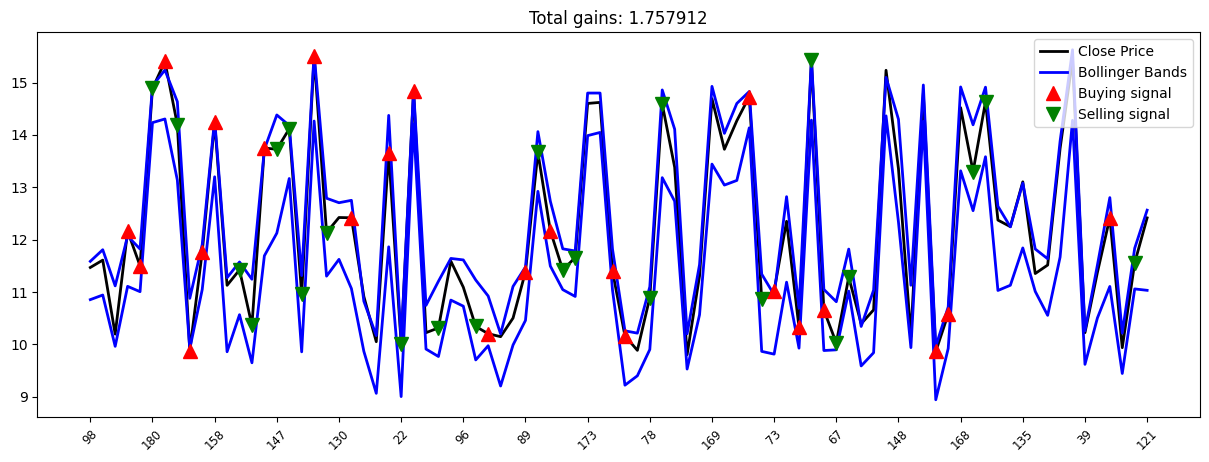

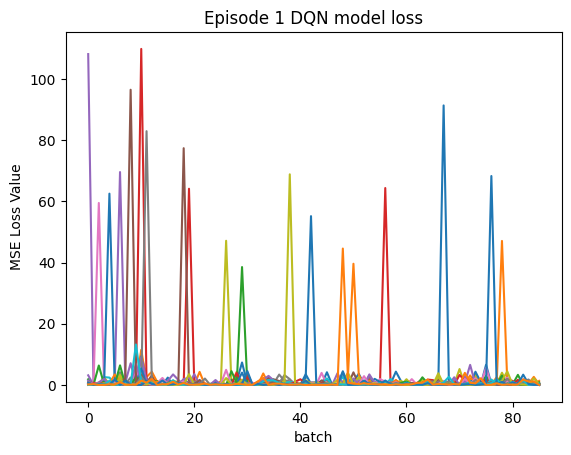

Running episode 2/2:   0%|          | 0/86 [00:00<?, ?it/s]

Action: Buy, Price: [10.1940403]
Action: Buy, Price: [12.16166496]
Action: Buy, Price: [11.4986496]
Action: Sell, Price: [14.19579124], Profit: [4.00175095]
Action: Sell, Price: [14.24784565], Profit: [2.08618069]
Action: Sell, Price: [11.12629604], Profit: [-0.37235355]
Action: Buy, Price: [12.13451672]
Action: Sell, Price: [12.42193985], Profit: [0.28742313]
Action: Buy, Price: [10.91334438]
Action: Sell, Price: [10.04908371], Profit: [-0.86426067]
Action: Buy, Price: [13.65606403]
Action: Buy, Price: [10.01197338]
Action: Sell, Price: [14.83763504], Profit: [1.18157101]
Action: Buy, Price: [10.22143841]
Action: Buy, Price: [10.31284523]
Action: Buy, Price: [11.58756733]
Action: Sell, Price: [11.09043026], Profit: [1.07845688]
Action: Sell, Price: [10.34024239], Profit: [0.11880398]
Action: Sell, Price: [10.14522266], Profit: [-0.16762257]
Action: Sell, Price: [10.50039196], Profit: [-1.08717537]
Action: Buy, Price: [10.89267159]
Action: Buy, Price: [14.5888176]
Action: Sell, Price: 

/tmp/ipykernel_600673/4164842749.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('Total gains: %f'%(profit))


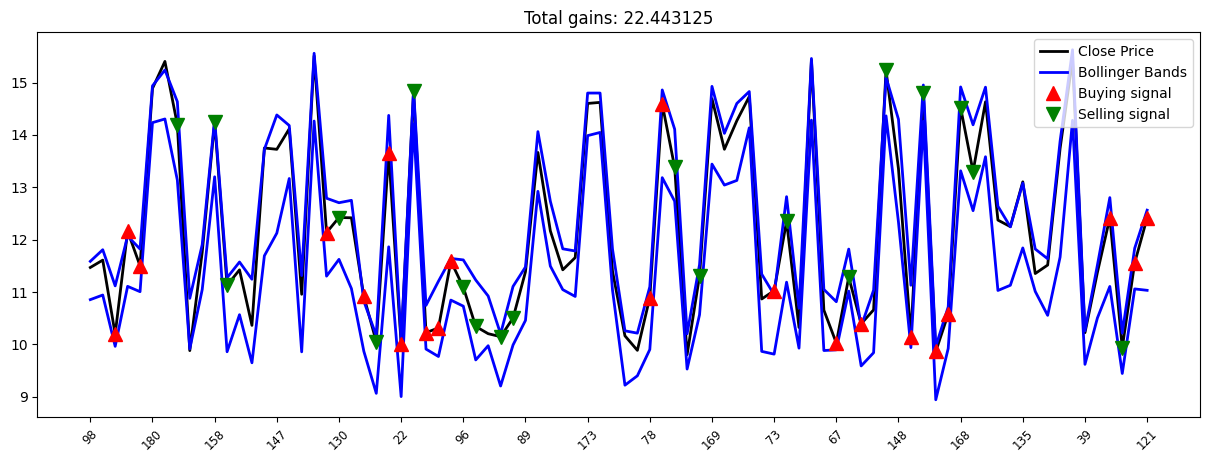

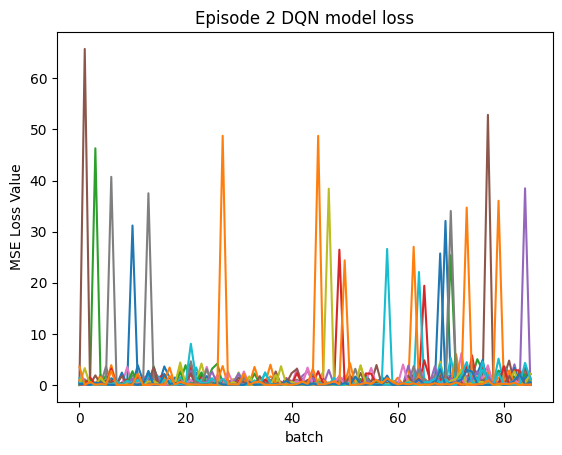

Model Config Before Saving: {'name': 'dqn_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'state_size': 3, 'action_size': 3}
Training Elapsed time: 479.70 seconds


In [49]:
# Start time
start_time = time.time()

batch_losses = []
num_batches_trained = 0

for e in range(episode_count + 1):
    state = X_train[0]  # Set the initial state (first row of X_train)
    
    # Initialize variables
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []  # Reset inventory
    states_sell = []
    states_buy = []
    
    for t in tqdm(range(l), desc=f'Running episode {e}/{episode_count}'):
        # Get action (you should define the agent's action method, for example using Q-learning)
        #print(f"State shape before act: {state.shape}")
        action = agent.act(state)
        
        # Get the next state (could be X_train[t+1] or something similar)
        next_state = X_train[t + 1] if t + 1 < l else state  # Example: Next state is the next row
        
        reward = 0  # Initialize reward for current time step

        if action == 1:  # Buy
            buy_price = X_train_true_price[t]  # The price at time step t
            agent.inventory.append(buy_price)  # Store the buy price in the inventory
            states_buy.append(t)  # Store the time step when buy happens
            
            print(f"Action: Buy, Price: {buy_price}")

        elif action == 2 and len(agent.inventory) > 0:  # Sell
            bought_price = agent.inventory.pop(0)  # Remove the first element (bought price)
            sell_price = X_train_true_price[t]  # The price at time step t
            trade_profit = sell_price - bought_price  # Profit from this trade
            
            reward = max(trade_profit, 0)  # Positive reward for profit, or 0 if no profit
            
            if trade_profit >= 0:
                total_winners += 1
            else:
                total_losers += 1

            total_profit += trade_profit  # Add trade profit to total profit
            states_sell.append(t)  # Store the time step when sell happens
            
            print(f"Action: Sell, Price: {sell_price}, Profit: {trade_profit}")

        done = True if t == l - 1 else False  # End of episode if last timestep

        # Store the details of the state and reward to memory (used by experience replay)
        agent.memory.append((state, action, reward, next_state, done))
        
        state = next_state  # Set the next state as current state for the next iteration

        # Print total profit and plot behavior of the current episode when the episode is finished
        if done:
            print(f"batch_losses type: {type(batch_losses[num_batches_trained:len(batch_losses)])}")
            
            print('--------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit: {total_profit}')
            print(f'Total Winners: {total_winners}')
            print(f'Total Losers: {total_losers}')
            print(f'Max Loss: {max(batch_losses[num_batches_trained:len(batch_losses)])}')
            
            segment = batch_losses[num_batches_trained:len(batch_losses)]
            # Flatten if nested
            if segment and isinstance(segment[0], list):
                segment = [item for sublist in segment for item in sublist]

            # Ensure all elements are numeric
            numeric_losses = [x for x in segment if isinstance(x, (int, float))]
            total_loss = sum(numeric_losses)

            print(f"Total Loss: {total_loss}")

            print('--------------------------------')
            plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower, states_buy, states_sell, total_profit)
            plot_losses(batch_losses[num_batches_trained:len(batch_losses)], f'Episode {e} DQN model loss')
            num_batches_trained = len(batch_losses)

        # Perform experience replay if memory size is greater than batch size
        if len(agent.memory) > batch_size:
            loss = agent.exp_replay(batch_size)
            batch_losses.append(loss)

    if e % 2 == 0:
        # Save model every 2 episodes
        print("Model Config Before Saving:", agent.model.get_config())
        agent.model.save(f'model_ep{e}.keras')
        
# End time
end_time = time.time()

# Elapsed time in seconds
elapsed_time = end_time - start_time
print(f"Training Elapsed time: {elapsed_time:.2f} seconds")

### Plot Training Loss

In [50]:
def plot_losses(losses, title='Training Loss'):
    """
    Plot the training losses over batches.

    Args:
    - losses (list or array-like): List of loss values for each batch.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Batch Loss')
    plt.title(title)
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.grid(True)
    #plt.legend()
    plt.show()

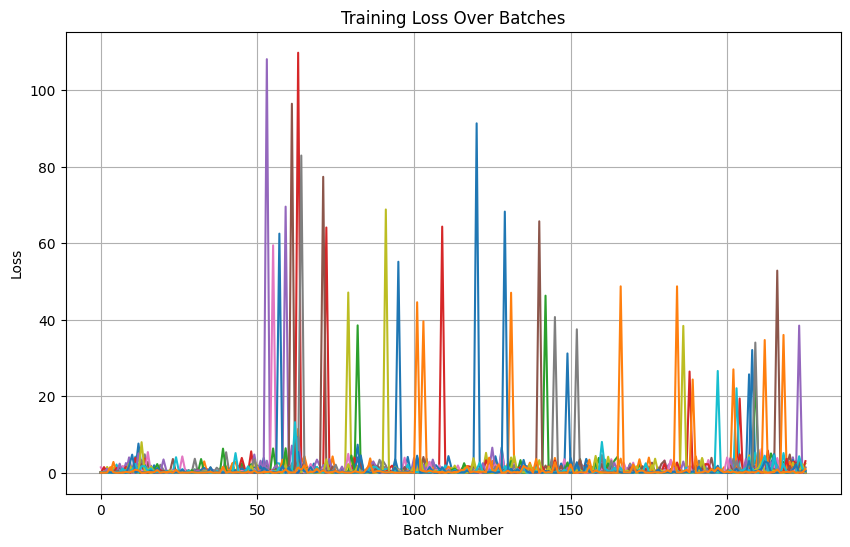

In [51]:
# Use the plot_losses function to plot all batch_losses for the entire training round
plot_losses(batch_losses, title='Training Loss Over Batches')

# 9. Test the trained agent 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

### Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [52]:
# Get the trained model
print(f"[test the trained agent] window_size={window_size}; num_features={X_test.shape[1]}")
agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'model_ep{episode_count}.keras')
agent.inventory = []

[test the trained agent] window_size=1; num_features=3
Deserialization Config: {'name': 'dqn_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'state_size': 3, 'action_size': 3}
Model Config After Loading: {'name': 'dqn_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'state_size': 3, 'action_size': 3}


In [53]:
# Get true prices for inverse transformation
X_test_true_price = normalizer_close.inverse_transform(X_test[:, idx_close].reshape(-1, 1))
X_test_true_bb_upper = normalizer_bb_upper.inverse_transform(X_test[:, idx_bb_upper].reshape(-1, 1))
X_test_true_bb_lower = normalizer_bb_lower.inverse_transform(X_test[:, idx_bb_lower].reshape(-1, 1))

### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

In [54]:
# X_test is a 2D array of shape (num_samples, num_features)
X_test.shape

(86, 3)

In [55]:
l_test = len(X_test)
states_buy_test = []
states_sell_test = []
window_size = 1
state = X_test[:window_size + 1]

print(f"[Run the Test] window_size={window_size}")
print(f"[Run the Test] state.shape={state.shape}")

[Run the Test] window_size=1
[Run the Test] state.shape=(2, 3)


In [56]:
state = state.flatten()[:agent.state_size]  # Ensure it matches agent.state_size
state = state.reshape(1, agent.state_size)  # Reshape for the agent

print(f"Initial state shape: {state.shape}, Expected: {(1, agent.state_size)}")

Initial state shape: (1, 3), Expected: (1, 3)


In [57]:
for t in range(l_test):
    # Choose an action (0: hold, 1: buy, 2: sell)
    #print(f"[Run the Test] Current state shape: {state.shape}, Expected: {(1, agent.state_size)}")
    action = agent.act(state)
    
    # Get the next state
    next_state = get_state(X_test, t + 1, window_size + 1)
    #print(f"[Run the Test] Current next state shape: {next_state.shape}, Expected: {(1, agent.state_size)}")
    
    # Initialize reward
    reward = 0

    if action == 1:  # Buy
        # Add current price to inventory
        agent.inventory.append(X_test_true_price[t, 0])
        
        # Save index of buy action
        states_buy_test.append(t)
        #print(f"Buy: {X_test_true_price[t, 0]}")
        buy_price = X_test_true_price[t, 0]
        print(f'Buy: {format_price(buy_price)}')

    elif action == 2 and len(agent.inventory) > 0:  # Sell
        # Get the oldest bought price
        bought_price = agent.inventory.pop(0)
        
        # Calculate profit
        trade_profit = X_test_true_price[t, 0] - bought_price
        
        # Define reward as positive profit
        reward = max(trade_profit, 0)
        
        # Add profit to total profit
        total_profit += trade_profit

        sell_price = X_test_true_price[t, 0]
        
        if trade_profit >= 0:
            print(f"Sell: {sell_price} | Profit: {format_price(trade_profit)}")
        else:
            print(f"Sell: {sell_price} | Loss: {format_price(trade_profit)}")

        states_sell_test.append(t)  # Save index of sell action

    # Check if it's the last time step
    done = True if t == l_test - 1 else False
    
    # append to memory so we can re-train on 'live' (test) data later    
    agent.memory.append((state, action, reward, next_state, done))
    
    # Move to the next state
    state = next_state

    if done:
        print('--------------------------------')
        print("Test Results")
        print(f'Total Profit: {format_price(total_profit.item())}')
        print('--------------------------------')

Buy: $11.08
Sell: 14.143238067626951 | Profit: $3.06
Buy: $14.12
Sell: 10.75095272064209 | Loss: -$3.37
Buy: $11.46
Sell: 14.50438404083252 | Profit: $3.05
Buy: $10.68
Buy: $10.72
Sell: 12.80649757385254 | Profit: $2.12
Sell: 15.513601303100586 | Profit: $4.80
Buy: $9.88
Buy: $12.27
Sell: 10.071249961853027 | Profit: $0.20
Buy: $9.71
Buy: $14.35
Sell: 9.937999725341797 | Loss: -$2.33
Buy: $10.10
Sell: 13.790559768676758 | Profit: $4.08
Sell: 11.0578031539917 | Loss: -$3.30
Sell: 12.429909706115724 | Profit: $2.33
Buy: $11.89
Sell: 14.570635795593262 | Profit: $2.68
Buy: $14.44
Sell: 13.457806587219238 | Loss: -$0.98
Buy: $14.38
Sell: 11.83364486694336 | Loss: -$2.55
Buy: $11.22
Sell: 14.854820251464844 | Profit: $3.64
Buy: $10.93
Buy: $13.05
Sell: 10.037128448486328 | Loss: -$0.89
Buy: $10.38
Sell: 11.236383438110352 | Loss: -$1.82
Sell: 13.333024978637695 | Profit: $2.95
Buy: $12.89
Sell: 13.694917678833008 | Profit: $0.80
Buy: $14.71
Sell: 14.911109924316406 | Profit: $0.20
Buy: $10.

/tmp/ipykernel_600673/4164842749.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('Total gains: %f'%(profit))


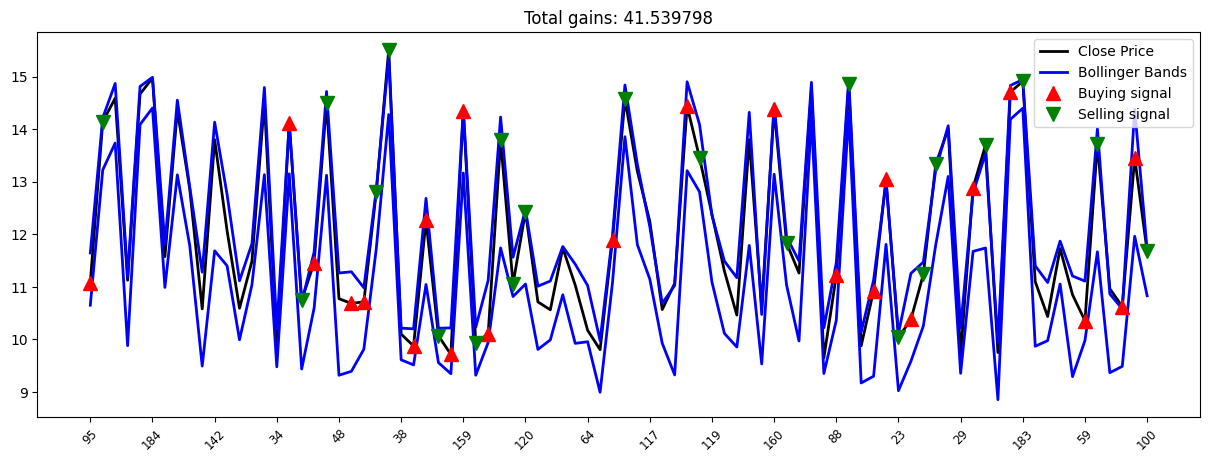

In [58]:
# Plot the behavior of the test set
plot_behavior(X_test_true_price, X_test_true_bb_upper, X_test_true_bb_lower, states_buy_test, states_sell_test, total_profit, train=False)